# Preparation

<b>Load Libraries</b>

In [56]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

# decomposition
from sklearn.decomposition import PCA

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# mlflow
import mlflow

# others
import re, os
from sklearn.base import BaseEstimator, TransformerMixin

In [57]:
# user-defined modules
##
cwd = os.getcwd()
os.chdir('../../../')

##
from usr_modules.mlflow_usr_defined import MLflowModel

##
os.chdir(cwd)

In [58]:
# model's type separation
parametric_models = ['LR']
non_parametric_models = ['KNN', 'SVM', 'CART']
ensample_models = ['ET', 'RF', 'GB', 'LGBM', 'XGB']

<b>Load Dataset</b>

In [59]:
# dataset
df_base = pd.read_csv('../../../dataset/cleaned/train.csv')

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

In [60]:
# cross validation
##
arr = df_base.values
le = LabelEncoder()

##
X, y = arr[:, :-1], le.fit_transform(arr[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

<b>MLflow</b>

In [61]:
# server creation & conneting
experiment_name = 'Features Engineering'
try:
    mlflow.create_experiment(
        name=experiment_name, 
        artifact_location='mlflow/_artifacts_store'
    )
    mlflow.set_experiment(
        experiment_name=experiment_name
    )
except:
    print(f'\'{experiment_name}\' has already existed.')
    mlflow.set_experiment(
        experiment_name=experiment_name
    )

'Features Engineering' has already existed.


<b>User-Defined Functions</b>

In [62]:
# parsed names:
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [63]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVM', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [64]:
# pipelines
def get_pipelines(
        base_models: list,
        ohe: list=[], other_encoders: list=[],
        scaling: list=[], pca: list=[], resampling: list=[], 
) -> list:
    ## [<name>, <estimator>]
    steps_num_pro = scaling + pca + resampling
    num_pro = [('num_pro', Pipeline(steps_num_pro), num_idxes)]

    ## [<name>, <estimator>, <idxes>]
    cat_pro = ohe + other_encoders
        
    ##
    if len(steps_num_pro) != 0:
        transformers = num_pro + cat_pro
    else:
        transformers = cat_pro
    ct = [('transform', ColumnTransformer(transformers, remainder='passthrough'))]

    ##
    pipelines = []
    for name, model in base_models:
        steps = ct + [(name, model)]
        pipelines.append((name, Pipeline(steps)))
        
    return pipelines

In [65]:
# kflold results
def get_kfold_results(models: list, X: np.ndarray, y: np.ndarray) -> dict:
    ##
    kfold_results = dict()
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        kfold_results[name] = cv_results

    return kfold_results

In [66]:
# selected models
def get_selected_base_models(names_to_choose: list) -> list:
    models = load_base_models()
    selected_models = [(name, model) for name, model in models if name in names_to_choose]

    return selected_models

In [67]:
# kfold visualization
def plot_kfold_results(kfold_results: dict):
    ##
    data_to_plot = pd.DataFrame(kfold_results)

    ##
    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

<b>User-Defined Classes</b>

In [68]:
# class SFS Base
class FS_BaseUserDefinedTransformer(BaseEstimator, TransformerMixin):
    ## 
    def __init__(self, 
                 ohe=None, other_encoders=None,
                 scaling: list=[], factor_analysis: list=[]) -> None:
        ###
        self.scaling, self.factor_analysis = scaling, factor_analysis
        ### 
        self.ohe, self.other_encoders = ohe, other_encoders


    ##
    def _check_ndim(self, X: np.ndarray) -> tuple[np.ndarray, int]:
        ###
        if X.ndim == 2:
            X_ = X
            num_iters = X.shape[1]
        else:
            X_ = X.reshape(-1, 1)
            num_iters = 1

        return X_, num_iters
    
    ##
    def _category_detection(self, X: np.ndarray) -> tuple[list, list, np.ndarray]:
        ###
        num_idxes, cat_idxes = [], []

        ### check dimension
        X_, num_iters = self._check_ndim(X=X)

        ###
        for i in range(num_iters):
            try:
                X_[:1, i].astype(float)
                num_idxes.append(i)
            except:
                cat_idxes.append(i)
        
        return num_idxes, cat_idxes, X_
    
    ##
    def _get_transformers(self, cat_idxes: list=[], num_idxes: list=[]) -> list:
        if len(num_idxes) == 0:
            transformers = self.cat_pro
        elif len(cat_idxes) == 0:
            transformers = self.num_pro
        else:
            transformers = self.num_pro + self.cat_pro

        return transformers 
    
    ## 
    def fit(self, X: np.ndarray, y=None):
        ###
        transformers = self._get_transformers(self.cat_idxes, self.num_idxes)
        self.ct = ColumnTransformer(transformers, remainder='passthrough')
        self.ct.fit(self.X_fit_)

        return self
    
    ##
    def transform(self, X: np.ndarray, y=None):
        X_, _ = self._check_ndim(X=X)

        return self.ct.transform(X=X_)

In [69]:
# Onehot_Scaling_Pca
class SFS_OSP(FS_BaseUserDefinedTransformer):
    def fit(self, X: np.ndarray, y=None):
        ###
        self.num_idxes, self.cat_idxes, self.X_fit_ = self._category_detection(X)

        ###
        steps = self.scaling + self.factor_analysis
        self.num_pro = [('num_pro', Pipeline(steps), self.num_idxes)]

        self.cat_pro = [('cat_pro', self.ohe, self.cat_idxes)]

        ###
        super().fit(X=X)
        
        return self

# 1. Baseline Evaluation

In [46]:
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

# base models
models = load_base_models()

## encoding
encoding = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=encoding
)

## kfold results
kfold_results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.13228050685782308 (0.0541376961381269)
KNN: 0.3590482148333225 (0.08163408925075537)
SVM: 0.0 (0.0)
CART: 0.7245797152903675 (0.05720312340837783)
ET: 0.4966795486623164 (0.08863618516027774)
RF: 0.6495066416070949 (0.08256237321866079)
GB: 0.7634863694867654 (0.05642273223649661)
LGBM: 0.7904782196037831 (0.052733861062937704)
XGB: 0.7788322510027165 (0.056953790262783334)


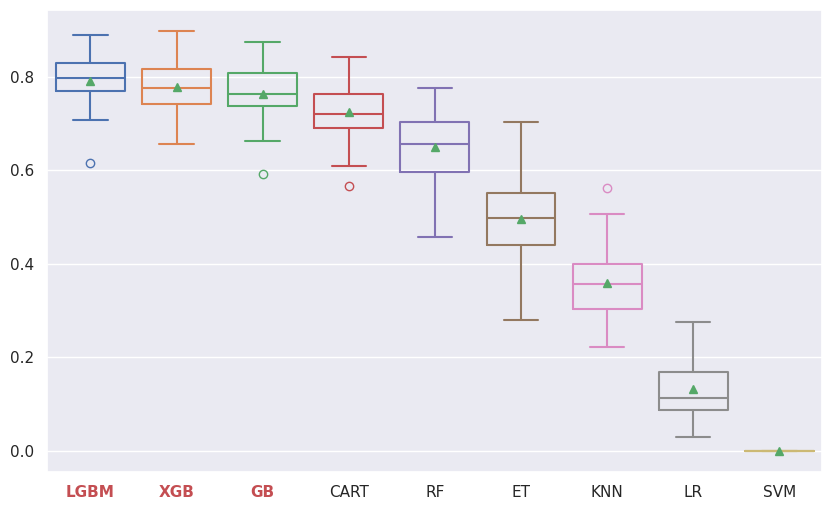

In [49]:
# visualizations
plot_kfold_results(
    kfold_results=kfold_results
)

In [51]:
# 
## base model
models = load_base_models()

## encoding
ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe
)

## mlflow
for name, pipeline in pipelines:
    ###
    pipeline.fit(X_train, y_train)

    ###
    val_predictions = pipeline.predict(X_test)
    val_fbeta = fbeta_score(
        y_true=y_test, y_pred=val_predictions, 
        beta=2
    )

    ### mlflow

# 2. 

In [39]:
## warnings
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', StandardScaler())]
)
## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)


[2024-07-21 15:30:58] Features: 1/19 -- score: 0.2381489118845433
[2024-07-21 15:31:30] Features: 2/19 -- score: 0.42408191254368577
[2024-07-21 15:32:00] Features: 3/19 -- score: 0.5754211684925191
[2024-07-21 15:32:29] Features: 4/19 -- score: 0.6225729598342019
[2024-07-21 15:33:01] Features: 5/19 -- score: 0.6584611009627147
[2024-07-21 15:33:28] Features: 6/19 -- score: 0.66052986385995
[2024-07-21 15:33:56] Features: 7/19 -- score: 0.6617499533205715
[2024-07-21 15:34:21] Features: 8/19 -- score: 0.6601361994499585
[2024-07-21 15:34:47] Features: 9/19 -- score: 0.7311445443588926
[2024-07-21 15:35:10] Features: 10/19 -- score: 0.7990904116019475
[2024-07-21 15:35:44] Features: 11/19 -- score: 0.8020770922467613
[2024-07-21 15:35:52] Features: 12/19 -- score: 0.8020770922467613
[2024-07-21 15:36:09] Features: 13/19 -- score: 0.8005928428259913
[2024-07-21 15:36:25] Features: 14/19 -- score: 0.8008545466925517
[2024-07-21 15:36:40] Features: 15/19 -- score: 0.8014141696172937
[202

SequentialFeatureSelector(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=7),
                          estimator=Pipeline(steps=[('transformers',
                                                     SFS_OSP(ohe=OneHotEncoder(drop='first',
                                                                               sparse_output=False),
                                                             scaling=[('scaling',
                                                                       StandardScaler())])),
                                                    ('LGBM',
                                                     LGBMClassifier(n_jobs=-1,
                                                                    verbose=-1))]),
                          k_features=(1, 19),
                          scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                          verbose=2)

In [13]:
## warnings
simplefilter(action='ignore')

## transformers
transformers = SFS_OSP(
    ohe=OneHotEncoder(drop='first', sparse_output=False), 
    scaling=[('scaling', PowerTransformer(method='yeo-johnson', standardize=True))]
)
## base model
base_model = get_selected_base_models(
    names_to_choose=['LGBM']
)

## pipeline
pipeline = Pipeline(
    steps=[('transformers', transformers)] + base_model
)

## sfs: forward
sfs = SequentialFeatureSelector(
    estimator=pipeline, 
    k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7),
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(X_train, y_train)


[2024-07-22 09:46:24] Features: 1/19 -- score: 0.23735039060793678
[2024-07-22 09:47:11] Features: 2/19 -- score: 0.42582041867224146
[2024-07-22 09:47:49] Features: 3/19 -- score: 0.5774183734798274
[2024-07-22 09:48:32] Features: 4/19 -- score: 0.6238530809892006
[2024-07-22 09:49:15] Features: 5/19 -- score: 0.6581735954421309
[2024-07-22 09:49:36] Features: 6/19 -- score: 0.6586658214158743
[2024-07-22 09:50:35] Features: 7/19 -- score: 0.7236601632131298
[2024-07-22 09:50:54] Features: 8/19 -- score: 0.8006204713894784
[2024-07-22 09:51:23] Features: 9/19 -- score: 0.8043225746011307
[2024-07-22 09:51:53] Features: 10/19 -- score: 0.8054731887556635
[2024-07-22 09:52:19] Features: 11/19 -- score: 0.8090817933195367
[2024-07-22 09:52:56] Features: 12/19 -- score: 0.8090817933195367
[2024-07-22 09:53:07] Features: 13/19 -- score: 0.8045225948431872
[2024-07-22 09:53:25] Features: 14/19 -- score: 0.8039057746144053
[2024-07-22 09:53:42] Features: 15/19 -- score: 0.8016731581905101
[

SequentialFeatureSelector(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=7),
                          estimator=Pipeline(steps=[('transformers',
                                                     SFS_OSP(ohe=OneHotEncoder(drop='first',
                                                                               sparse_output=False),
                                                             scaling=[('scaling',
                                                                       PowerTransformer())])),
                                                    ('LGBM',
                                                     LGBMClassifier(n_jobs=-1,
                                                                    verbose=-1))]),
                          k_features=(1, 19),
                          scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                          verbose=2)